# 2021-01-06 • ROC

Calculate & draw an ROC curve for connecton detection performance in the N-to-1 simulation.

## Setup

In [1]:
from voltage_to_wiring_sim.support.notebook_init import *

Preloading: numpy, numba, matplotlib.pyplot, seaborn.
Importing from submodules … ✔
Imported `np`, `mpl`, `plt`, `sns`
Imported codebase (`voltage_to_wiring_sim`) as `v`
Imported `*` from `v.support.units`
Setup autoreload


In [2]:
v.print_reproducibility_info()

This cell was last run by `tfiers` on `yoga`<br>on **Mon 11 Jan** 2021, at 01:52 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/cf7b78350885d7e1b6847f713a034ebbcdc516c1
) (Mon 11 Jan 2021, 01:08).

No uncommitted changes

## Sim

In [13]:
params = v.N_to_1_SimParams(
    time_grid = v.TimeGrid(duration = 60 * second, timestep = 0.1 * ms),
    num_spike_trains = 30,
    p_connected = 0.5,
    spike_rate = 20 * Hz,
    Δg_syn = 0.8 * nS,
    τ_syn = 7 * ms,
    neuron_params = v.neuron_params.cortical_RS,
    imaging_spike_SNR = 2,
);

In [14]:
sim_data = v.N_to_1_simulation.simulate(params);

In [15]:
v.pprint(sim_data, values=False)

N_to_1_SimData
--------------
spike_trains       : NDArray[(num_spike_trains,), SpikeTimes]
is_connected       : NDArray[(num_spike_trains,), bool]
all_incoming_spikes: SpikeTimes
g_syn              : Signal
izh_output         : IzhikevichOutput
VI_signal          : Signal


In [16]:
zoom = params.time_grid.zoom(start=1 * second, duration=0.1 * second);

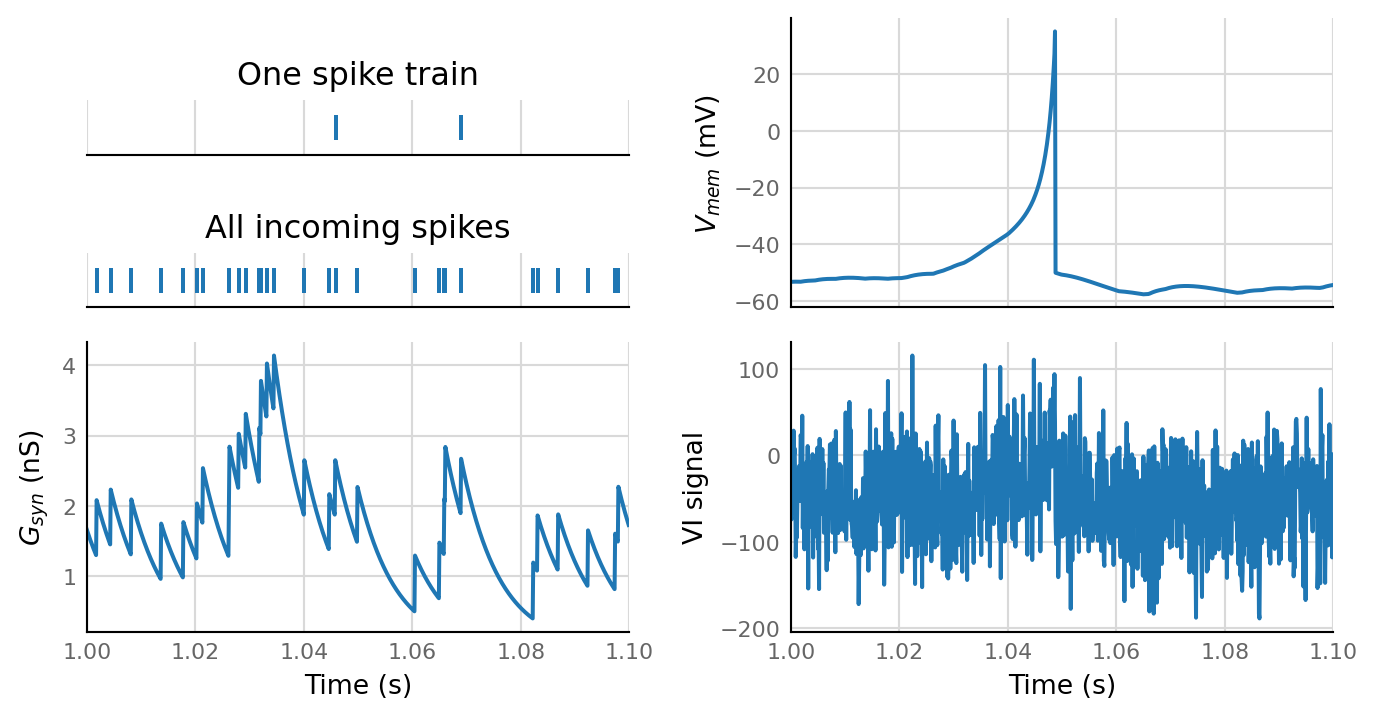

In [17]:
v.N_to_1_simulation.plot(sim_data, zoom)

## Permutation tests

In [18]:
from tqdm import tqdm as timed_loop

test_data = []
test_summaries = []

for spike_train in timed_loop(sim_data.spike_trains):
    data, summary = v.test_connection(spike_train, 
                                      sim_data.VI_signal,
                                      window_duration=100 * ms,
                                      num_shuffles=100)
    test_data.append(data)
    test_summaries.append(summary)

100%|██████████| 30/30 [00:01<00:00, 23.66it/s]


## Classify as connected

In [19]:
def apply_threshold(connection_test_summaries, p_value_threshold):
    is_classified_as_connected = np.array(
        [summary.p_value < p_value_threshold
         for summary in connection_test_summaries]
    )
    return is_classified_as_connected

is_classified_as_connected = apply_threshold(test_summaries, p_value_threshold = 0.1)

array([ True,  True,  True,  True, False,  True, False, False,  True,
       False,  True,  True, False,  True,  True, False, False, False,
       False, False,  True, False, False, False, False, False, False,
       False, False, False])

## Evaluate classification

In [20]:
def evaluate_classification(is_classified_as_connected, is_connected):
    is_TP = is_classified_as_connected & is_connected
    is_FP = is_classified_as_connected & ~is_connected
    is_TN = ~is_classified_as_connected & ~is_connected
    is_FN = ~is_classified_as_connected & is_connected
    num_TP = np.sum(is_TP)
    num_FP = np.sum(is_FP)
    num_TN = np.sum(is_TN)
    num_FN = np.sum(is_FN)
    TPR = num_TP / (num_TP + num_FN)
    FPR = num_FP / (num_FP + num_TN)
    return ClassificationEvaluation(
        is_TP, is_FP, is_TN, is_FN, num_TP, num_FP, num_TN, num_FN, TPR, FPR
    )


# boilerplate: (programming lang should generate this automatically)

from dataclasses import dataclass
from nptyping import NDArray
from typing import Any


NumSpikeTrains = Any
IndexArray = NDArray[(NumSpikeTrains,), bool]

@dataclass
class ClassificationEvaluation:
    is_TP: IndexArray
    is_FP: IndexArray
    is_TN: IndexArray
    is_FN: IndexArray
    num_TP: int
    num_FP: int
    num_TN: int
    num_FN: int
    TPR: float
    FPR: float


# test

classification_eval = evaluate_classification(is_classified_as_connected, sim_data.is_connected)
v.pprint(classification_eval)

ClassificationEvaluation
------------------------
 is_TP = array([ True,...False, False])
 is_FP = array([False,...False, False])
 is_TN = array([False,... True,  True])
 is_FN = array([False,...False, False])
num_TP = 10
num_FP = 1
num_TN = 14
num_FN = 5
   TPR = 0.6667
   FPR = 0.06667


## Sweep threshold

In [21]:
from typing import List

@dataclass
class ThresholdResult:
    p_value_threshold: float
    is_classified_as_connected: IndexArray
    evaluation: ClassificationEvaluation

ThresholdSweep = List[ThresholdResult]

def sweep_threshold(connection_test_summaries, sim_data):
    results = []
    for p_value_threshold in np.logspace(-3, 0):
        is_classified_as_connected = apply_threshold(connection_test_summaries, p_value_threshold)
        evaluation = evaluate_classification(is_classified_as_connected, sim_data.is_connected)
        results.append(ThresholdResult(p_value_threshold, is_classified_as_connected, evaluation))
    return results

threshold_results = sweep_threshold(test_summaries, sim_data);

## ROC curve

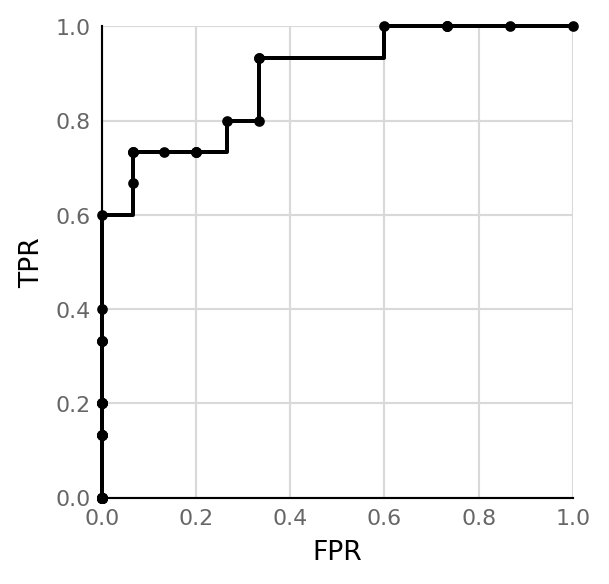

In [22]:
p_value_thresholds = [threshold_result.p_value_threshold for threshold_result in threshold_results]
TPRs = [threshold_result.evaluation.TPR for threshold_result in threshold_results]
FPRs = [threshold_result.evaluation.FPR for threshold_result in threshold_results]

fig, ax = plt.subplots()
ax.step(FPRs, TPRs, 'k.-', where='post', clip_on=False)
ax.set_aspect('equal')
ax.set(xlabel="FPR", ylabel="TPR", xlim=(0,1), ylim=(0,1));

## Reproducibility

In [9]:
v.print_reproducibility_info(verbose=True)

This cell was last run by `tfiers` on `yoga`<br>on **Thu 07 Jan** 2021, at 13:35 (UTC+0100).

[Last git commit](https://github.com/tfiers/voltage-to-wiring-sim/tree/1d6dcfe5863c45a4221e1d3268fb8c94828008e6
) (Thu 07 Jan 2021, 13:19).

Uncommited changes to:
```
 M notebooks/2021-01-06__ROC.ipynb
```

Platform:

Windows-10
CPython 3.8.5 (C:\conda\python.exe)
Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz


Dependencies of `voltage_to_wiring_sim` and their installed versions:

numpy                1.19.2
matplotlib           3.3.3
numba                0.52.0
seaborn              0.11.1
scipy                1.6.0
scikit-learn         0.24.0
preload              2.2
py-cpuinfo           7.0.0
nptyping             1.4.0
tqdm                 4.55.1
